In [1]:
###To-Do:
#save weights for future use in HDF5: https://github.com/ajhalthor/Keras_LSTM_Text_Generator/blob/master/Text%20Generator%20(LSTM%20%2B%20Keras).ipynb
#also build a LSTM using multiple files similar to above
#Pandas-profiling
#    Super awesome data EDA library
#Cufflinks & Plotly
#    Makes plotly even more amazing
#pprint

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import datetime as dt
import requests
from io import StringIO
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras import backend as k
import pandas_datareader
from tensorflow.python.keras.callbacks import LambdaCallback
import lstm_c

#for printing in prediction plot
pred_window = 50
epoch_num = 500

In [3]:
def get_stock_data(stock_name, normalized=0):
    
    #load data
    start = dt.datetime(1995,1,1)
    end   = dt.date.today()
    df = pandas_datareader.data.DataReader(stock_name,'yahoo',start,end)
    df.drop(columns=['Low','Adj Close', 'Volume'], axis=1, inplace=True) 
    return df

In [4]:
stock_name = 'GOOG'
df = get_stock_data(stock_name,0)
df.tail()

,High,Open,Close
Date,,,
2019-06-17,1099.180054,1086.280029,1092.500000
2019-06-18,1116.390015,1109.689941,1103.599976
2019-06-19,1107.000000,1105.599976,1102.329956
2019-06-20,1120.119995,1119.989990,1111.420044
2019-06-21,1124.109985,1109.239990,1121.880005


In [5]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [6]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.head(5)

,High,Open,Close
Date,,,
2004-08-19,0.051694,0.049677,0.049846
2004-08-20,0.054188,0.050179,0.053805
2004-08-23,0.056373,0.055017,0.054347
2004-08-24,0.055439,0.055261,0.052096
2004-08-25,0.053651,0.052141,0.052658


In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [8]:
def build_model(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='random_uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='random_uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [9]:

window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3357, 5, 3)
y_train (3357,)
X_test (373, 5, 3)
y_test (373,)


/Users/arideltoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
model = build_model([3,window,1])

In [29]:
trained_epochs = []
tracker_cb = LambdaCallback(on_epoch_begin=lambda epoch, logs:print(epoch))

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epoch_num,
    validation_split=0.1,
    verbose=0,
    callbacks=[tracker_cb]
    )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [30]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


In [31]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

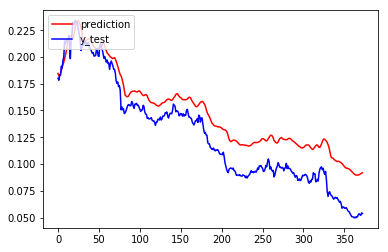

In [32]:

import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [79]:
#model.save('my_model.h5')
#model = load_model('my_model.h5')

yo


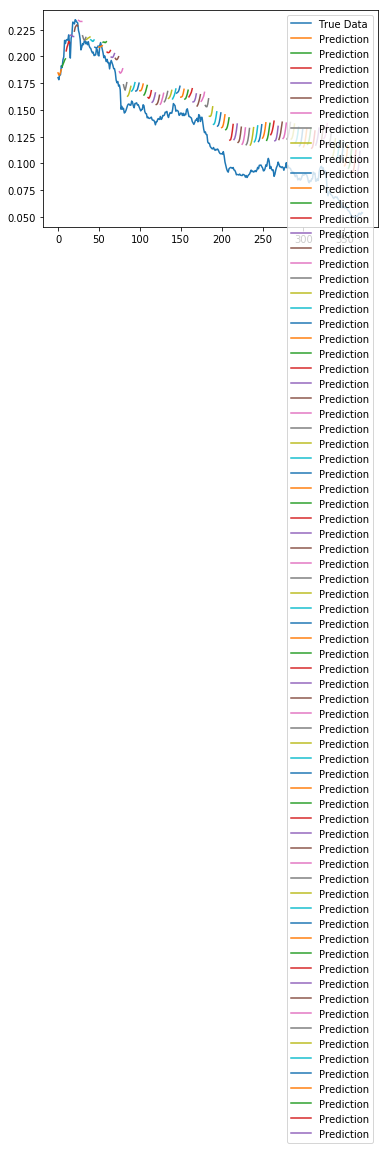

In [80]:
predictions = lstm_c.predict_sequences_multiple(model, X_test, pred_window, pred_window)
lstm_c.plot_results_multiple(predictions, y_test, pred_window)